In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pylab as pl
from IPython import display
from parameters import *
from micro import *
from aero_init import *
from parcel import *
from condensation import *
from collision import *
from analysis import *
from print_plot import *

import itertools
import matplotlib

%load_ext autoreload
%autoreload 2

# Intialization
## Input parameter

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create the widgets for the variables
dt_widget      = widgets.BoundedFloatText(description='dt [s]:', min = 1.0, max = 5.0, value = 1.0)
nt_widget      = widgets.IntText(description='nt:', value = 3600)
N_aero1_widget = widgets.IntSlider(description='N_aero1:', min=0, max=5000, value=500)
N_aero2_widget = widgets.IntSlider(description='N_aero2:', min=0, max=5000, value=200)
Condensation_widget = widgets.Checkbox(description='Condensation:', value=True)
Collision_widget = widgets.Checkbox(description='Collision:', value=False)

# Display the widgets
display(dt_widget, nt_widget, N_aero1_widget, N_aero2_widget,Condensation_widget,Collision_widget) #button)

BoundedFloatText(value=1.0, description='dt [s]:', max=5.0, min=1.0)

IntText(value=3600, description='nt:')

IntSlider(value=500, description='N_aero1:', max=5000)

IntSlider(value=200, description='N_aero2:', max=5000)

Checkbox(value=True, description='Condensation:')

Checkbox(value=False, description='Collision:')

In [3]:
# section for widgets for parcel info
T_widget = widgets.BoundedFloatText(description='T [K]:', min = 200.0, max = 320.0, step = 0.1, value=293.2)
P_widget = widgets.BoundedFloatText(description='P [Pa]:', min = 950.0E2, max = 1050.0E2, step = 1, value=1013.0E2)
# why are q and RH given here?
RH_widget= widgets.BoundedFloatText(description='RH [-]:', min = 0.01, max = 0.99, step = 0.01, value=0.88)
w_widget = widgets.BoundedFloatText(description='w [m/s]:', min = 0.0, max = 10, step = 0.1, value=0.5)
max_z_widget = widgets.BoundedFloatText(description='max_z [m]:', min = 0.0, max = 20000., step = 0.1, value=3600.)

# Display widgets
display('Parcel initial parameters: ', T_widget, P_widget, RH_widget, w_widget, max_z_widget)

'Parcel initial parameters: '

BoundedFloatText(value=293.2, description='T [K]:', max=320.0, min=200.0, step=0.1)

BoundedFloatText(value=101300.0, description='P [Pa]:', max=105000.0, min=95000.0, step=1.0)

BoundedFloatText(value=0.88, description='RH [-]:', max=0.99, min=0.01, step=0.01)

BoundedFloatText(value=0.5, description='w [m/s]:', max=10.0, step=0.1)

BoundedFloatText(value=3600.0, description='max_z [m]:', max=20000.0, step=0.1)

In [5]:
n_particles = 500

dt = dt_widget.value #0.5
nt = nt_widget.value #100

do_condensation = Condensation_widget.value  #True
do_collision    = Collision_widget.value  #False

#parcel info. 
T_parcel   = T_widget.value
P_parcel   = P_widget.value
RH_parcel  = RH_widget.value
w_parcel   = w_widget.value
z_parcel   = 0.0 #m

# RH to q conversion
q_parcel    = RH_parcel * esatw( T_parcel ) / ( P_parcel - RH_parcel * esatw( T_parcel ) ) * r_a / rv

collision_start_time = 2000.0
max_z = collision_start_time * w_parcel 

#aerosol initialization
mode_aero_init = "weighting_factor"
N_aero = [500.0E6, 250.0E6]#[1e6*var3_widget.value,1e6*var4_widget.value]#[100.0E6, 50.0E6]
mu_aero = [np.log(100.0E-9), np.log(500.0E-9)]
sigma_aero = [np.log(2), np.log(1.5), np.log(1.2)]

rho_aero = 2170.0
molecular_weight_aero = 0.058443

n_particles_mode1 = n_particles // 2  # Number of particles for the first mode
n_particles_mode2 = n_particles - n_particles_mode1  # Number of particles for the second mode

# Generate log-normal distribution for the first mode
mode1_values = np.random.lognormal(mu_aero[0], sigma_aero[0], n_particles_mode1)

# Generate log-normal distribution for the second mode
mode2_values = np.random.lognormal(mu_aero[1], sigma_aero[1], n_particles_mode2)

# Combine the values from both modes
aero_r_seed = np.concatenate((mode1_values, mode2_values))
n_bins = 100
log_edges = np.logspace(np.log10(0.1E-6), np.log10(1000.0E-6), n_bins+1)
spectra_arr = np.zeros((nt+1,n_bins))

qa_ts,qc_ts,qr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)
na_ts,nc_ts,nr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)

# Time step routine

In [7]:
dz=0
rho_parcel, V_parcel, air_mass_parcel =  parcel_rho(P_parcel, T_parcel)
#Aerosol init
T_parcel, q_parcel, particles_list = aero_init(mode_aero_init, n_particles, P_parcel, T_parcel,q_parcel, aero_r_seed,N_aero, mu_aero,sigma_aero,rho_aero,molecular_weight_aero)
#parcel routine
spectra_arr[0],qa_ts[0], qc_ts[0],qr_ts[0], na_ts[0], nc_ts[0], nr_ts[0] = qc_qr_analysis(particles_list,air_mass_parcel,log_edges)

#fig, ax = plt.subplots()
for t in range(nt):
    time = (t+1)*dt
    #Parcel ascending
    dz = w_parcel * dt
    if z_parcel < max_z: 
        z_parcel, T_parcel, rho_parcel, V_parcel, air_mass_parcel = ascend_parcel(z_parcel, T_parcel,P_parcel, dz)
    
    #Condensational Growth
    dq_liq = 0.0
    if do_condensation:
        particles_list, T_parcel, q_parcel = drop_condensation(particles_list, T_parcel, q_parcel, P_parcel, dt, air_mass_parcel, rho_aero, molecular_weight_aero)

    #Collisional Growth
    if do_collision and time > collision_start_time:
        particles_list = collection(dt, particles_list,rho_parcel, rho_liq, P_parcel, T_parcel)
    #Analysis
    spectra_arr[t+1],qa_ts[t+1], qc_ts[t+1],qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1] = qc_qr_analysis(particles_list,air_mass_parcel,log_edges)
    
    #Visulaization at every second
    if (time%1) ==0:
        RH_parcel = (q_parcel * P_parcel / (q_parcel + r_a / rv)) / esatw( T_parcel ) 
        print_output(t,dt, z_parcel, T_parcel, q_parcel, RH_parcel, qc_ts[t+1], qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1])
    #spec_plot(ax,spectra_arr, nt, log_edges)
    

ValueError: could not broadcast input array from shape (100) into shape (500)

/project/meteo/work/J.Lim/PyLCM_parcel/print_plot.py:21: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(np.arange(nt+1), log_edges[1:], spectra_arr.T, norm=matplotlib.colors.LogNorm())


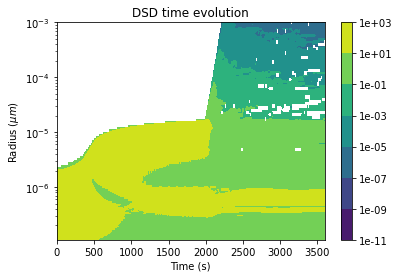

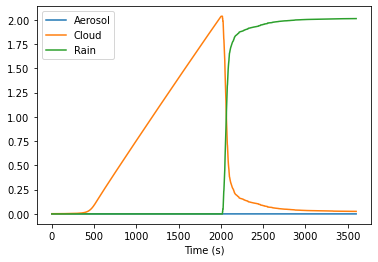

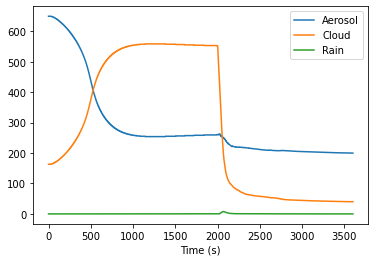

In [337]:
fig, ax = plt.subplots()
spec_plot(ax,spectra_arr/1e6, nt,dt,log_edges)

for i in range(nt):
    plt.plot(log_edges*1e6, spectra_arr[i]/1e6)
    plt.yscale("log")
    plt.xscale("log")

plt.figure()
plt.plot(np.arange(nt+1),qa_ts*1e3, label = "Aerosol")
plt.plot(np.arange(nt+1),qc_ts*1e3, label = "Cloud")
plt.plot(np.arange(nt+1),qr_ts*1e3, label = "Rain")
plt.xlabel("Time (s)")
plt.legend()

plt.figure()
plt.plot(np.arange(nt+1),na_ts/1e6, label = "Aerosol")
plt.plot(np.arange(nt+1),nc_ts/1e6, label = "Cloud")
plt.plot(np.arange(nt+1),nr_ts/1e6, label = "Rain")
plt.xlabel("Time (s)")
plt.legend()